In [138]:
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import json
import warnings
import taxicab

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

CONFIG = "config/RO/Iasi/Timisoara.json"

MAX_LCS = 77
WALKING_SPEED_MS = 0.8 # meters per second
INFRASTRUCTURE_CUTOFF_DIST = 20 # meters

# Source: https://wiki.openstreetmap.org/wiki/Key:building?uselang=en-GB#Accommodation
# Source: https://wiki.openstreetmap.org/wiki/Key:shop / https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-GB
RESIDENTIAL_TAGS = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'dormitory', 'house', 'residential', 'semidetached_house', 'yes']}

# Structure: (<feature name>, <max score>, <filtering tags>)
AMENITY_TAGS = [
    # Public Transport
    ('public_transport', 5, {'public_transport': True}),
    # Bicycle Rental
    ('bike_rental', 2, {'amenity': ['bicycle_rental', 'kick-scooter_rental', 'escooter_rental']}),
    # Grocer
    ('grocer', 3, {'shop': ['supermarket', 'butcher', 'cheese', 'convenience', 'deli', 'dairy', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Pharmacy
    ('pharmacy', 3, {'shop': ['chemist'], 'amenity': ['pharmacy'], 'healthcare': ['pharmacy']}),
    # Bank
    ('bank', 2, {'amenity': ['bank', 'atm'], 'atm': True}),
    # Playground
    ('playground', 2, {'leisure': ['playground', 'pitch', 'track']}),
    # General Store
    ('general_store', 2, {'shop': ['supermarket', 'convenience', 'deli', 'greengrocer', 'health_food', 'department_store', 'general']}),
    # Clothes Store
    ('clothes_store', 2, {'shop': ['clothes', 'shoes']}),
    # Kindergarten
    ('kindergarten', 2, {'amenity': ['kindergarten'], 'building': ['kindergarten']}),
    # School
    ('school', 4, {'amenity': ['school'], 'building': ['school']}),
    # Restaurant
    ('restaurant', 2, {'amenity': ['restaurant', 'food_court', 'fast_food']}),
    # Cafe
    ('cafe', 2, {'amenity': ['cafe'], 'scop': ['coffee']}),
    # Dry Cleaner
    ('cleaner', 2, {'shop': ['dry_cleaning', 'laundry']}),
    # Beauty and grooming
    ('beauty', 2, {'shop': ['beauty', 'hairdresser']}),
    # Outdoor physical activities
    ('outdoor_sports', 2, {'leisure': ['disc_golf_course', 'dog_park', 'fishing', 'fitness_station', 'golf_course', 'horse_riding', 'pitch', 'stadium', 'track', 'stadium', 'swimming_area', 'water_park']}),
    # Indoor physical activities
    ('indoor_sports', 2, {'leisure': ['bowling_alley', 'dance', 'fitness_centre', 'ice_rink', 'sports_centre', 'sports_hall', 'swimming_pool', 'trampoline_park', 'water_park'], 'sport': ['gym']}),
    # Entertainment venue
    ('entertainment', 1, {
        'leisure': ['adult_gaming_centre', 'amusement_arcade', 'dance', 'miniature_golf'], 
        'amenity': ['arts_centre', 'casino', 'cinema', 'community_centre', 'conference_centre', 'events_venue', 'exhibition_centre', 'music_venue', 'nightclub', 'social_centre', 'theatre']
        }),
    # Hospital or clinic
    ('hospital', 1, {'amenity': ['clinic', 'hospital', 'doctors']}),
    # Bookstore or library
    ('bookstore', 1, {'shop': ['books'], 'amenity': ['library']}),
    # Museum
    ('museum', 1, {'tourism': ['museum', 'aquarium', 'zoo']}),
    # Art Gallery
    ('art_gallery', 1, {'tourism': ['artwork', 'gallery']}),
    # Park
    ('park', 2, {'leisure': ['park']}),
]

PARKING_TAGS = ['parking:left', 'parking:right', 'parking:both']
CYCLEWAY_BUFFER_TAGS = ['cycleway:buffer', 'cycleway:left:buffer', 'cycleway:right:buffer', 'cycleway:both:buffer']
ACCESSIBLE_TAGS = ['tactile_paving', 'wheelchair']

ox.config(useful_tags_way=['width', 'lit', 'maxspeed'] + PARKING_TAGS + CYCLEWAY_BUFFER_TAGS + ACCESSIBLE_TAGS)


In [141]:
config = json.load(open(CONFIG, 'r'))

place_id = config['placeId']
defaults = config.get('defaults', {})
globals = config.get('globals', {})

default_maxspeed = defaults.get('maxspeed', 50.0)
default_sidewalk_width = defaults.get('sidewalk_width', 1.0)
default_sidewalk_lit = defaults.get('sidewalk_lit', "no")
default_bikepath_width = defaults.get('bike_width', 1.0)
default_bikepath_lit = defaults.get('bike_lit', "no")

C:\Users\Catalin\AppData\Local\Temp\ipykernel_17188\1321100661.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='config/RO/Iasi/Timisoara.json' mode='r' encoding='cp1252'>
  config = json.load(open(CONFIG, 'r'))


In [143]:
def safe_query_graph(network_type=None, custom_filter=None):
    try:
        df = ox.graph_from_place(place_id, custom_filter=custom_filter, network_type=network_type, retain_all=True, simplify=True)
        return ox.project_graph(df)
    except ValueError as ex:
        print (ex)
        return nx.multidigraph.MultiDiGraph()
    
def safe_query_locations(tags):
    try:
        df = ox.features_from_place(place_id, tags).reset_index()
        df = ox.projection.project_gdf(df)
        return df
    except ox._errors.InsufficientResponseError as ex:
        return pd.DataFrame()


df_residential = ox.features_from_place(place_id, RESIDENTIAL_TAGS)
df_residential = ox.projection.project_gdf(df_residential)
df_residential = df_residential[df_residential['shop'].isnull()]
df_residential = df_residential[df_residential['amenity'].isnull()]
df_residential = df_residential[df_residential['leisure'].isnull()]
df_residential = df_residential[df_residential['tourism'].isnull()]
df_residential = df_residential[df_residential['office'].isnull()]
df_residential = df_residential.reset_index()

df_path_walk = safe_query_graph(network_type='walk')
df_path_bike = nx.compose(
    safe_query_graph(custom_filter='["highway"~"cycleway"]'), 
    safe_query_graph(custom_filter='["cycleway"~"track"]')
)
df_path_drive = safe_query_graph(network_type='drive')
df_path_all = ox.graph_from_place(place_id, simplify=True)

df_residential['edges_walk'], df_residential['edges_walk_dist'] = ox.nearest_edges(df_path_walk, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)
df_residential['edges_bike'], df_residential['edges_bike_dist'] = ox.nearest_edges(df_path_bike, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)
df_residential['edges_drive'], df_residential['edges_drive_dist'] = ox.nearest_edges(df_path_drive, df_residential.centroid.x, df_residential.centroid.y, return_dist=True)

df_amenities = []

for feature_name, score, tags in AMENITY_TAGS:
    print (f"Querying: {feature_name}")
    df = safe_query_locations(tags)
    df_amenities.append((feature_name, score, df))

KeyError: 'leisure'

<Figure size 640x480 with 0 Axes>

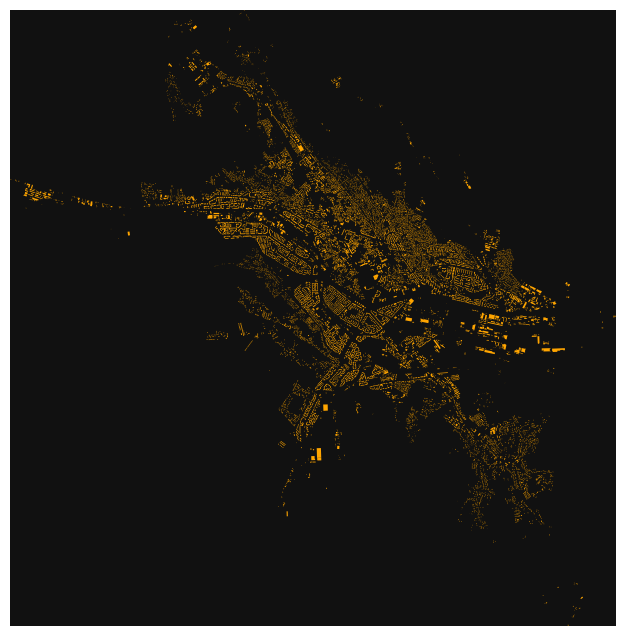

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [ ]:
plt.figure()

ox.plot_footprints(df_residential)
# ox.plot_graph(df_path_bike)

In [56]:
def distance_to_score(distance):
    min_time = distance / WALKING_SPEED_MS / 60

    if min_time > 25:
        return 0

    return min((25 - min_time) / 20, 1)

def calculate_walking_distance(df_dest, node):
    node_dest = df_dest[df_dest.index == node['index_right']]['geometry'].values[0].centroid
    node_source = node['geometry'].centroid

    try:
        print ("a")
        path = taxicab.distance.shortest_path(
            df_path_all, 
            (node_dest.y, node_dest.x), 
            (node_source.y, node_source.x)
        )
        print ("b")

        return path[0]
    except BaseException as ex:
        print (ex)
        return ox.distance.euclidean_dist_vec(node_dest.y, node_dest.x, node_source.y, node_source.x)

    return path[0]

def has_any_tag(node, tags):
    for tag in tags:
        if node.get(tag, 'no') != 'no':
            return True
    
    return False


def sidewalk_score(node):
    total_score = 0

    if node.get('edges_walk_dist', 1000) < INFRASTRUCTURE_CUTOFF_DIST:
        closest_street = df_path_walk.edges[node['edges_walk']]
        sidewalk_width = closest_street.get('width', default_sidewalk_width)

        if type(sidewalk_width) is list:
            sidewalk_width = sidewalk_width[0]

        sidewalk_width = float(sidewalk_width)

        if sidewalk_width < 1:
            return total_score
        
        total_score += 3

        if sidewalk_width >= 2:
            total_score += 1

        if closest_street.get("lit", default_sidewalk_lit) == 'yes':
            total_score += 1 

        if has_any_tag(node, ACCESSIBLE_TAGS):
            total_score += 2

        if closest_street.get("noise_db", 60) < 65:
            total_score += 3

        if closest_street.get("shaded", "no") == 'yes':
            total_score += 3

    return total_score

def bike_path_score(node):
    total_score = 0

    if node.get('edges_bike_dist', 1000) < INFRASTRUCTURE_CUTOFF_DIST:
        closest_path = df_path_bike.edges[node['edges_bike']]

        if float(closest_path.get('width', default_bikepath_width)) < 1.5:
            return total_score
        
        total_score += 3

        if closest_path.get("lit", default_bikepath_lit) == 'yes':
            total_score += 1 

        if has_any_tag(node, CYCLEWAY_BUFFER_TAGS):
            total_score += 1

    return total_score

def drive_path_score(node):
    total_score = 0

    if node.get('edges_drive_dist', 1000) < INFRASTRUCTURE_CUTOFF_DIST:
        closest_street = df_path_drive.edges[node['edges_drive']]
        max_speed = closest_street.get('maxspeed', default_maxspeed)

        if type(max_speed) is list:
            max_speed = max_speed[0]

        if type(max_speed) is str:
            max_speed = max_speed.lower()

        if max_speed in config["parameters"]:
            max_speed = config["parameters"][max_speed]
        else:
            max_speed = float(max_speed)

        if closest_street.get("traffic_calming", "no") == 'yes':
            total_score += 2

        if max_speed <= 30:
            total_score += 2

        if max_speed <= 15:
            total_score += 1 

        if closest_street.get("no_parking_enforced", "no") == 'yes':
            total_score += 1

        if has_any_tag(node, PARKING_TAGS):
            total_score += 1

    return total_score

df_residential["lcs_sidewalk"] = df_residential.apply(sidewalk_score, axis=1)
df_residential["lcs_bike_path"] = df_residential.apply(bike_path_score, axis=1)
df_residential["lcs_drive_path"] = df_residential.apply(drive_path_score, axis=1)

for feature_name, score, df in df_amenities:
    if df.empty:
        df_residential[f"lcs_{feature_name}"] = 0  
        continue

    df_joined = df_residential.sjoin_nearest(df, distance_col='dist', how='inner')

    # df_dist = score * df_joined.apply(lambda x: calculate_walking_distance(df, x), axis=1).apply(distance_to_score)
    df_dist = score * df_joined['dist'].apply(distance_to_score)
    df_dist = df_dist.groupby(df_dist.index).min()
    df_residential[f"lcs_{feature_name}"] = df_dist

df_residential['lcs'] = 0

for col in [col for col in df_residential.columns if col.startswith("lcs_")]:
    df_residential['lcs'] += df_residential[col]

if globals['yearly_aqi'] <= 150:
    df_residential['lcs'] += 3

df_residential['lcs_perc'] = df_residential['lcs'] * 1.0 / MAX_LCS * 100
    

TypeError: '<=' not supported between instances of 'str' and 'int'

In [15]:
def plot_feature(score_column, max_score = 5, figsize=(8, 8)):
    cmap = mpl.colormaps['RdYlGn']
    return ox.plot_footprints(df_residential, color=cmap((df_residential[score_column] * 1.0 / max_score)), bgcolor='#586282', figsize=figsize, show=False)


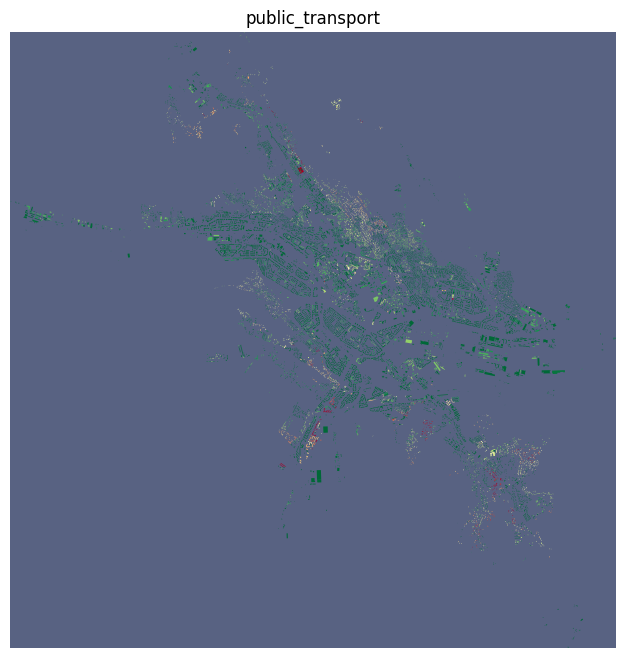

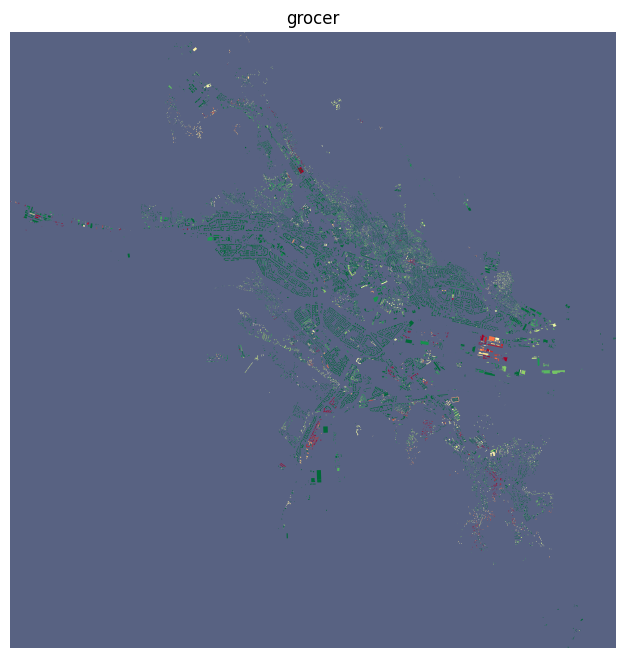

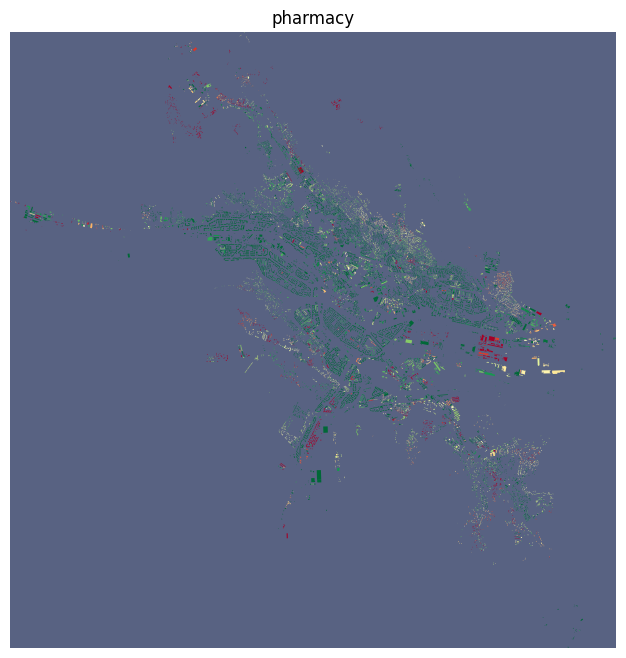

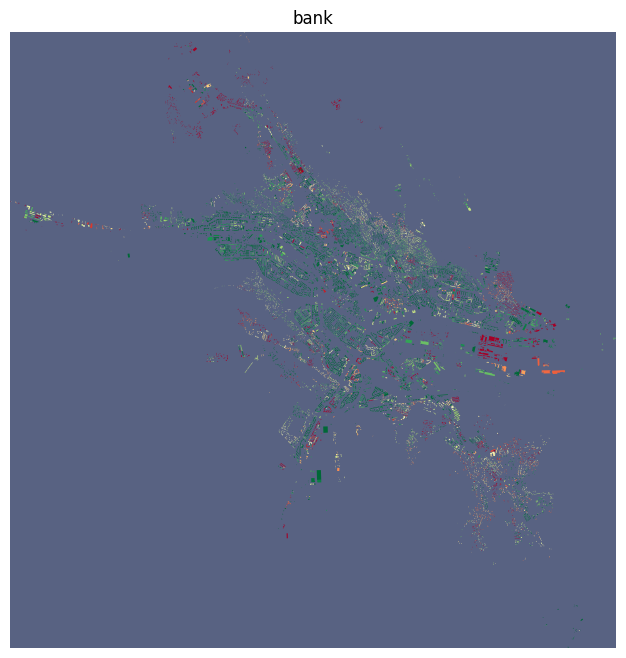

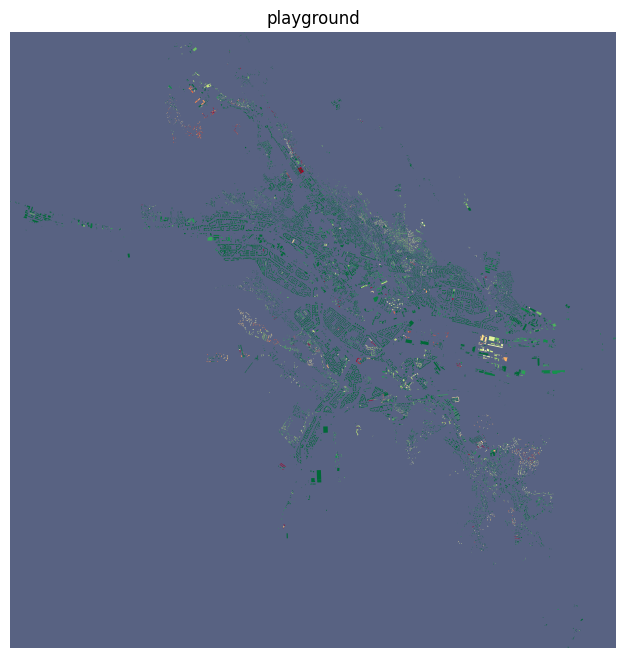

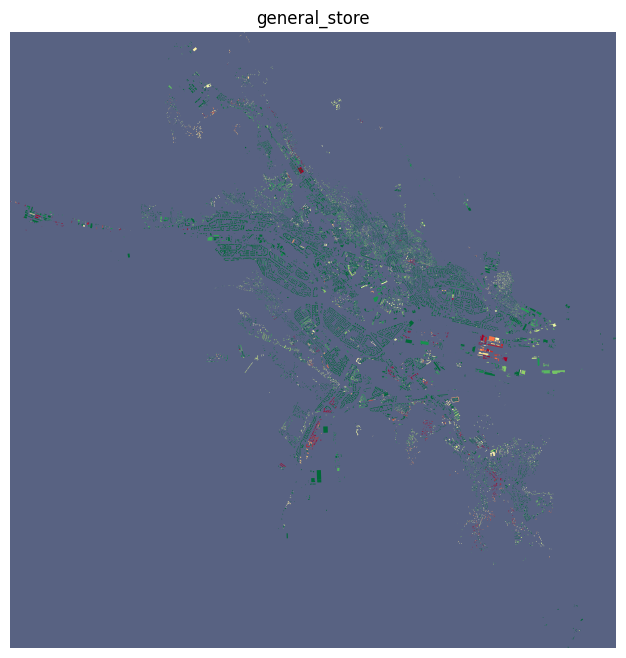

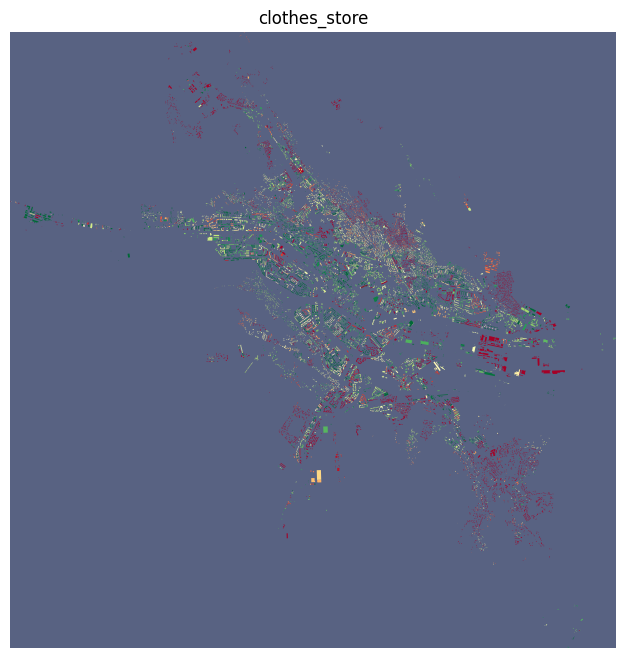

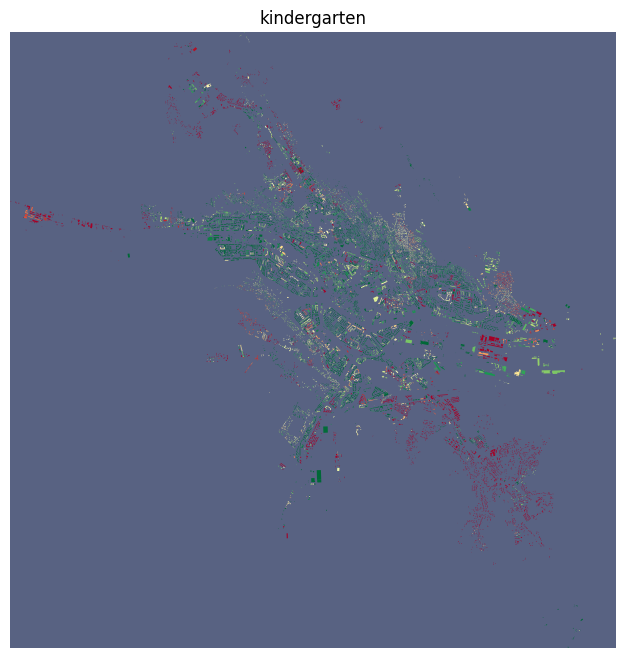

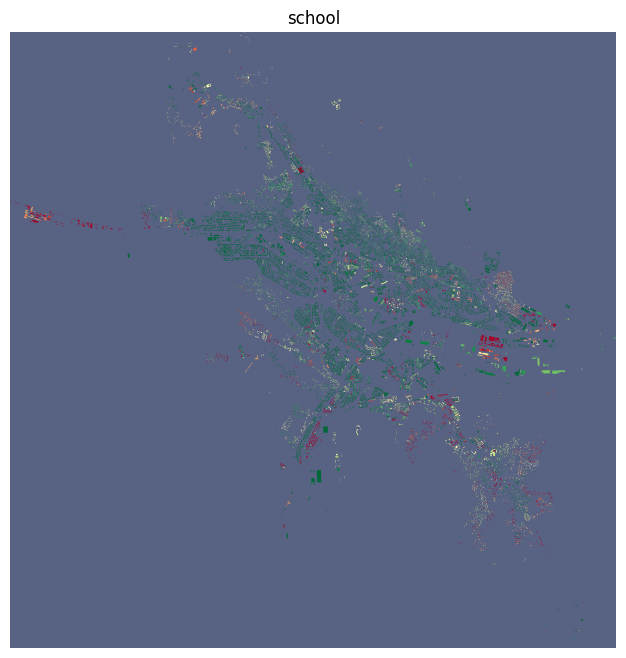

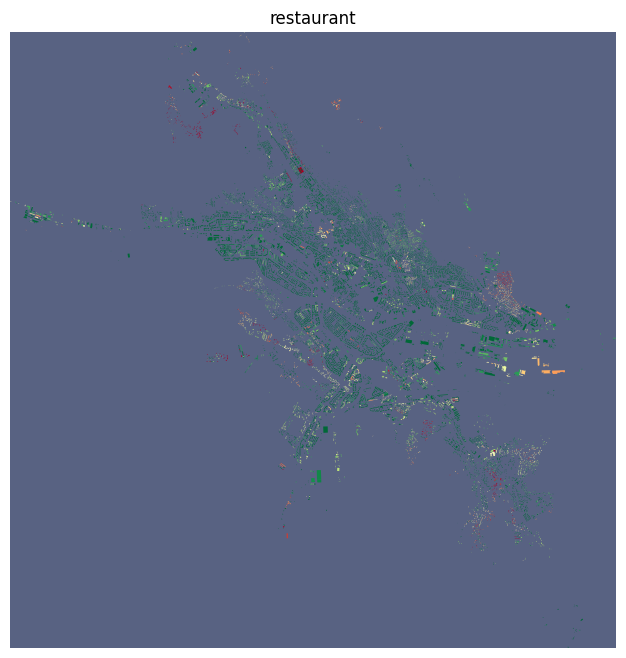

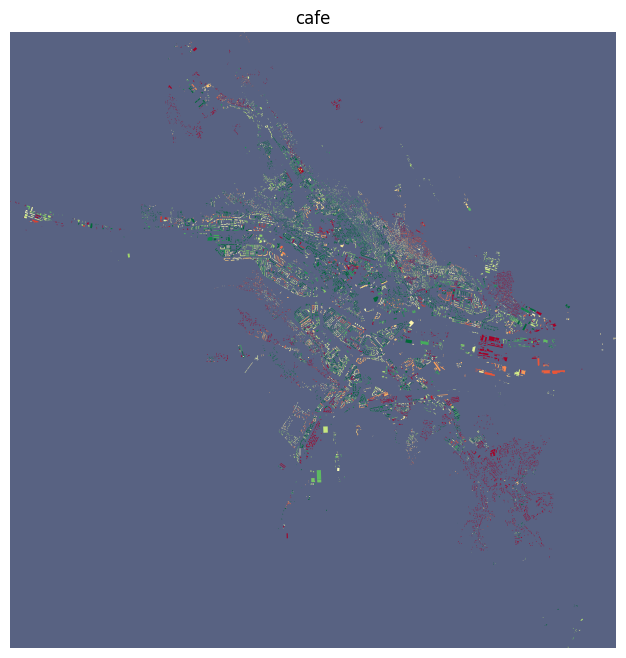

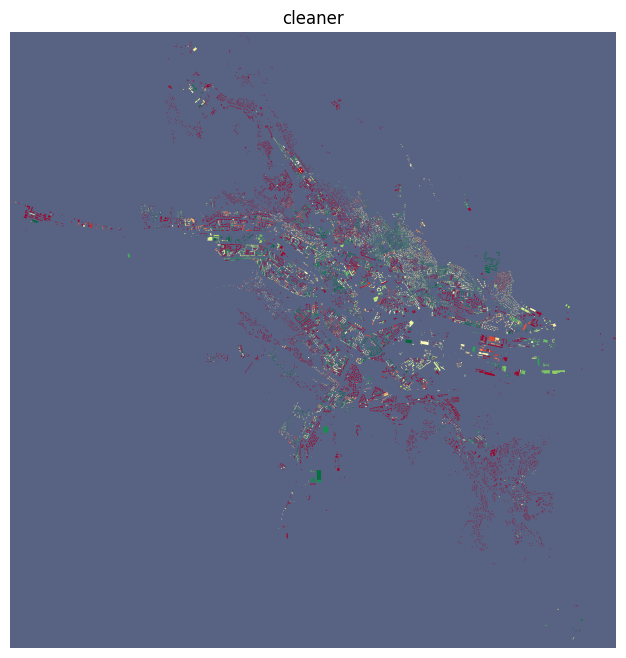

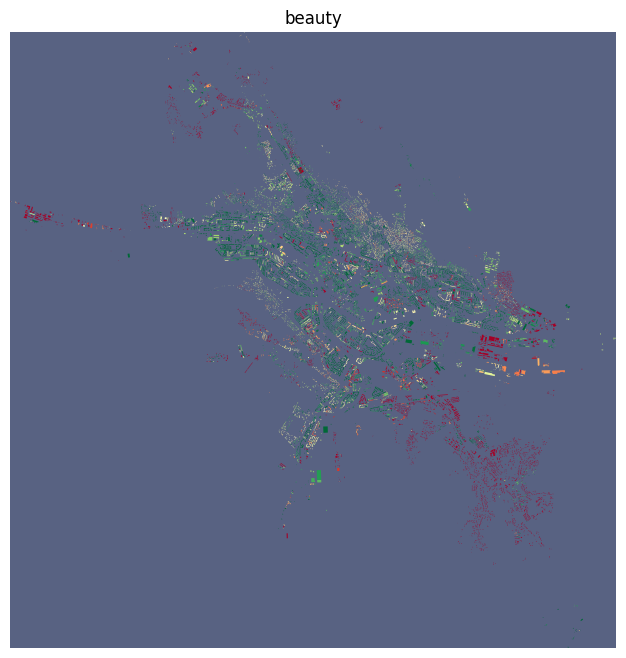

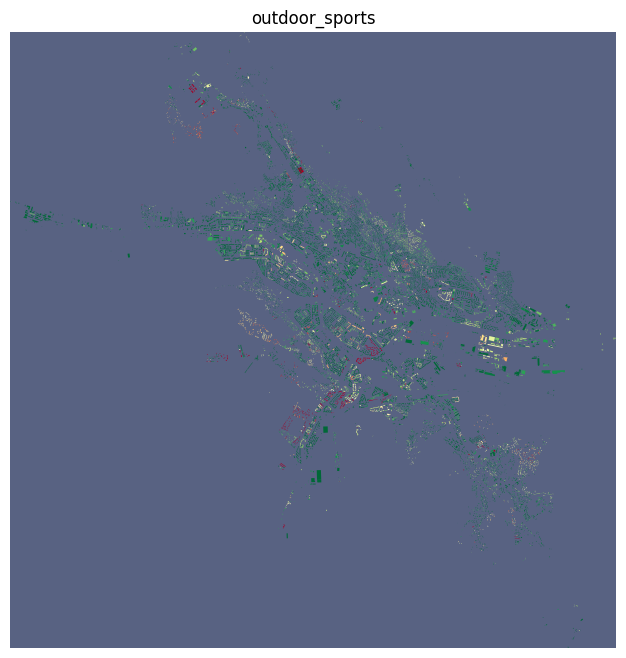

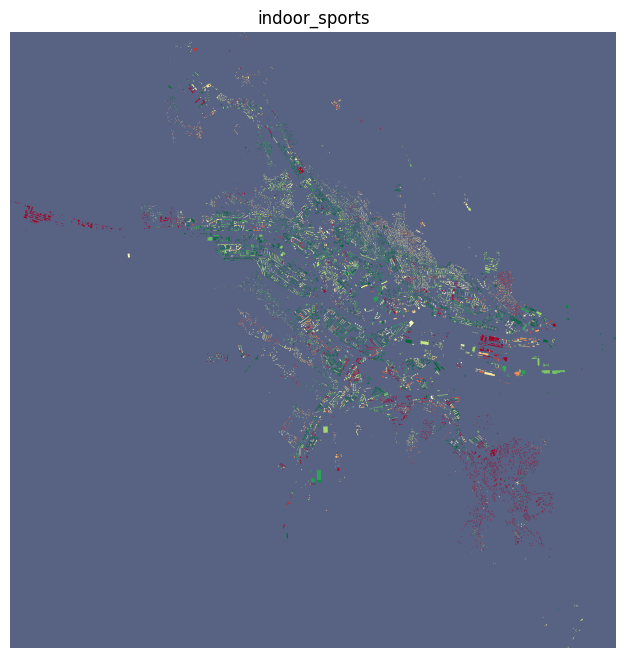

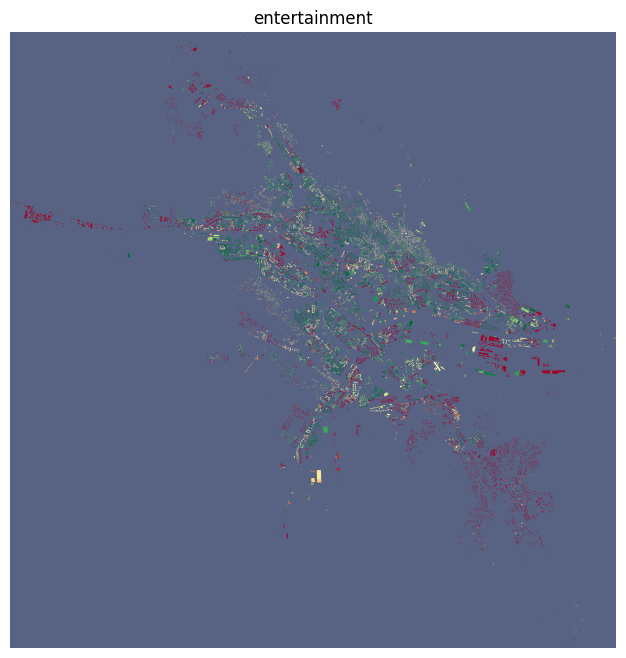

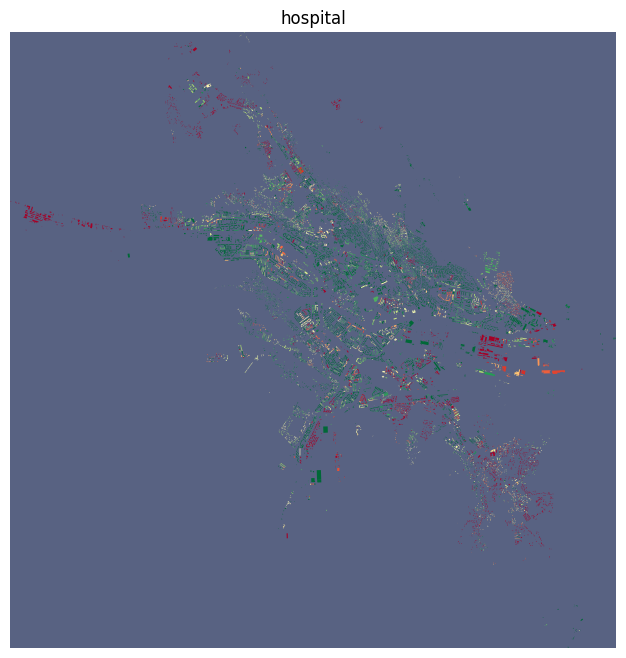

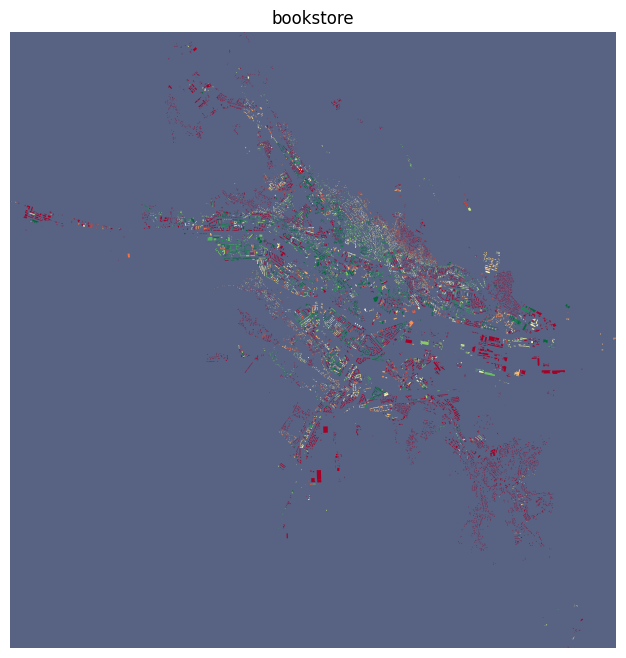

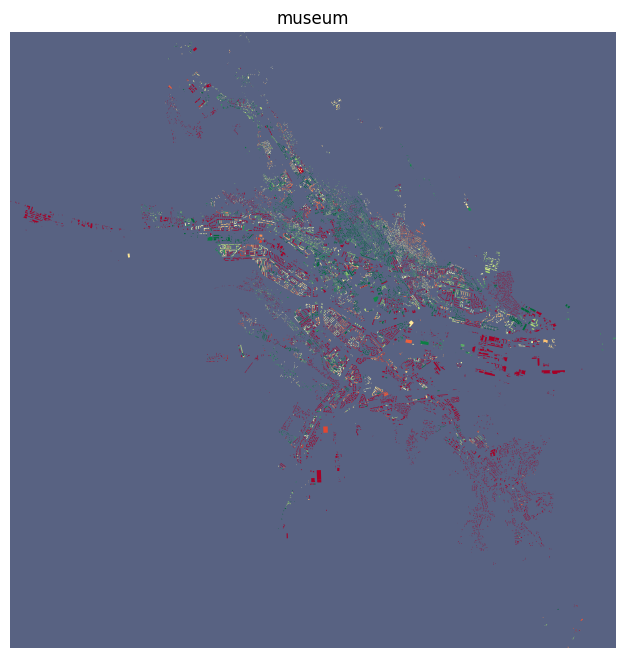

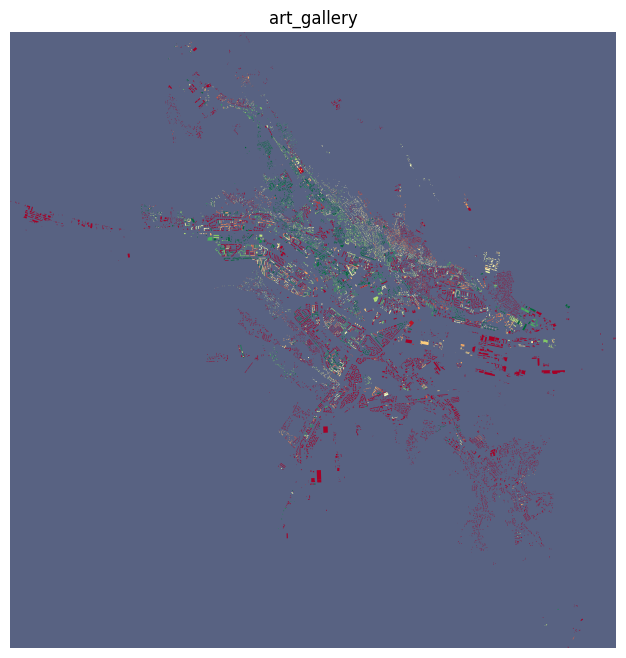

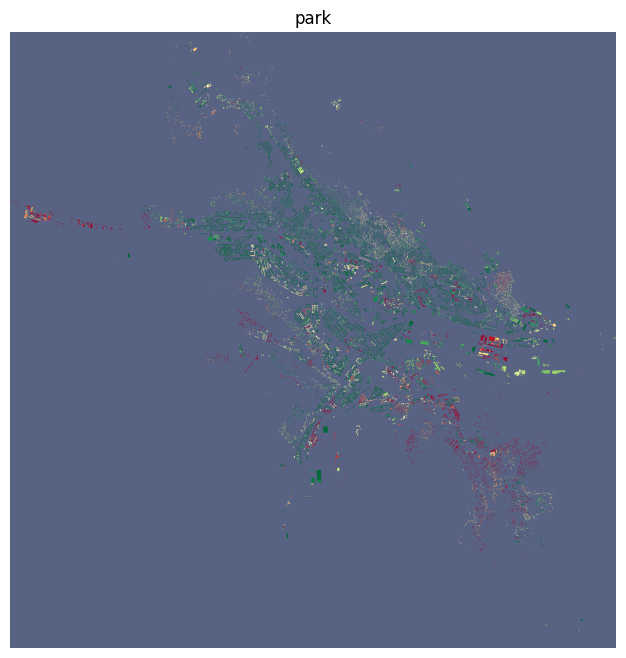

In [10]:
for feature_name, score, df in df_amenities:
    fig, ax = plot_feature(f'lcs_{feature_name}', max_score=score)
    ax.set_title(feature_name)
    plt.show()

(<Figure size 1600x1600 with 1 Axes>, <AxesSubplot: >)

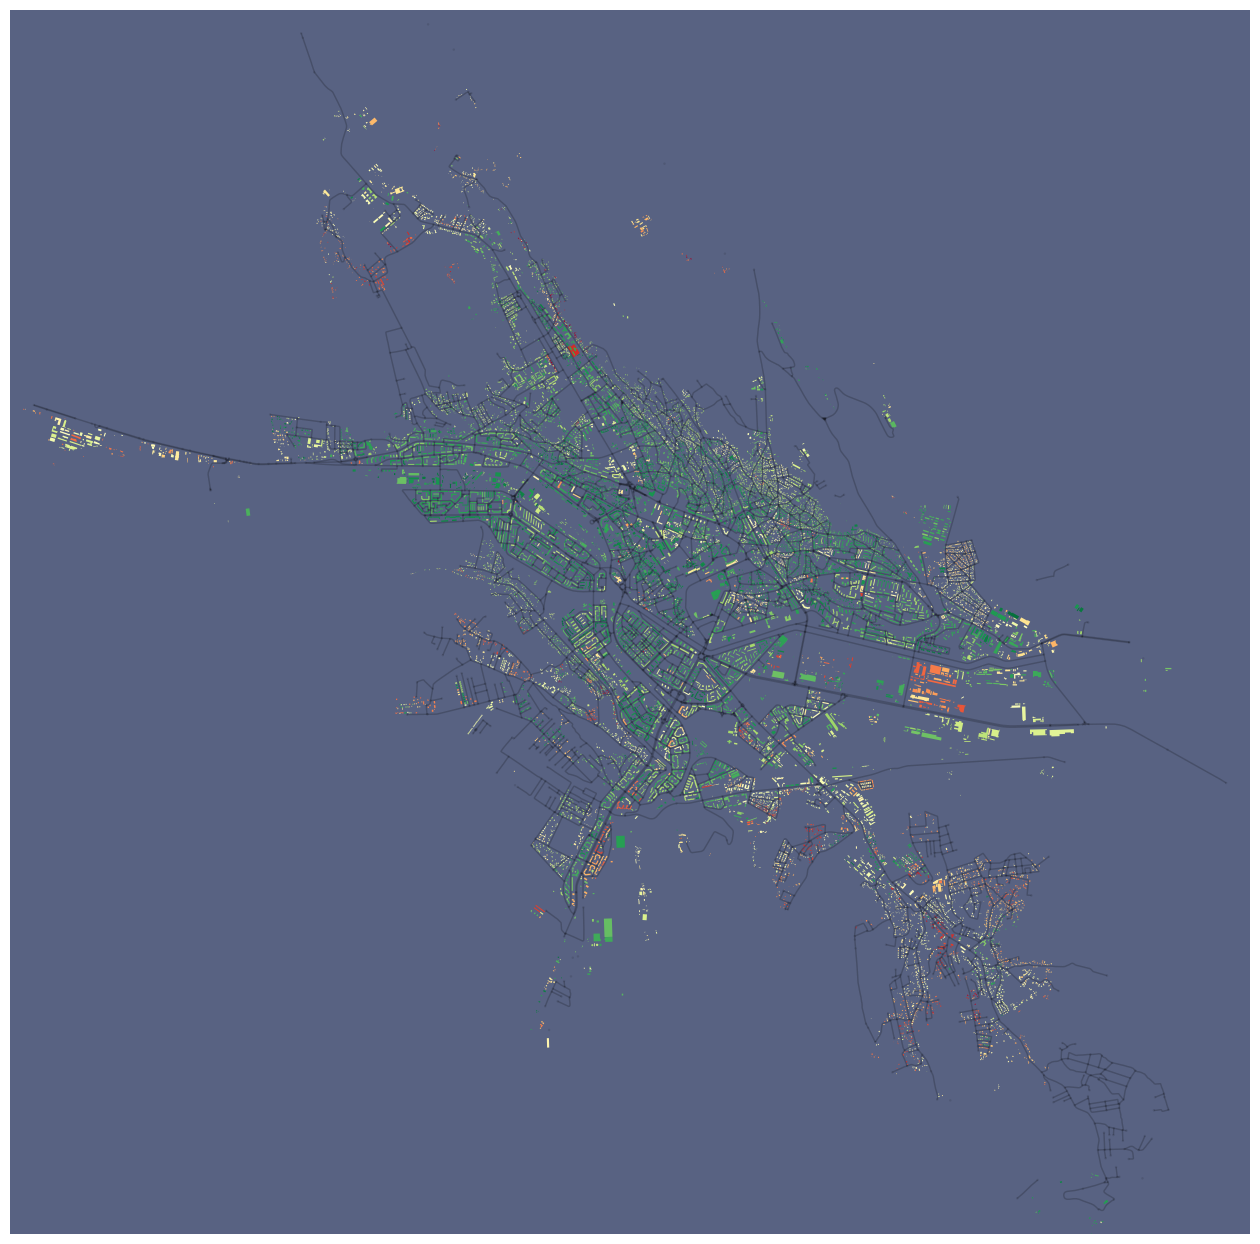

In [19]:
fig, ax = plot_feature("lcs", df_residential["lcs"].max(), figsize=(16,16))
ox.plot_graph(df_path_drive, show=False, close=False, ax=ax, edge_color='black', node_color='black', node_size=3, edge_alpha=0.1, node_alpha=0.1)

<AxesSubplot: >

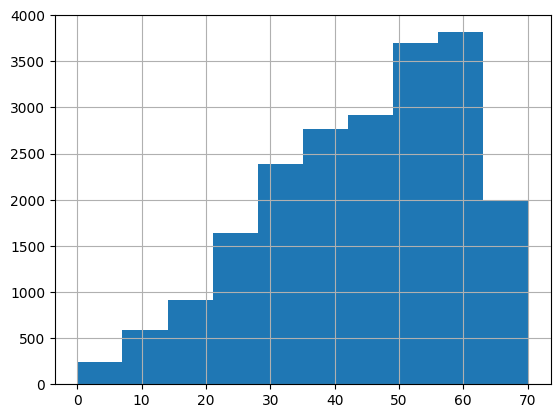

In [60]:
df_residential['lcs_perc'].hist()

Text(0.5, 1.06, '(Average LCS 44.54%)')

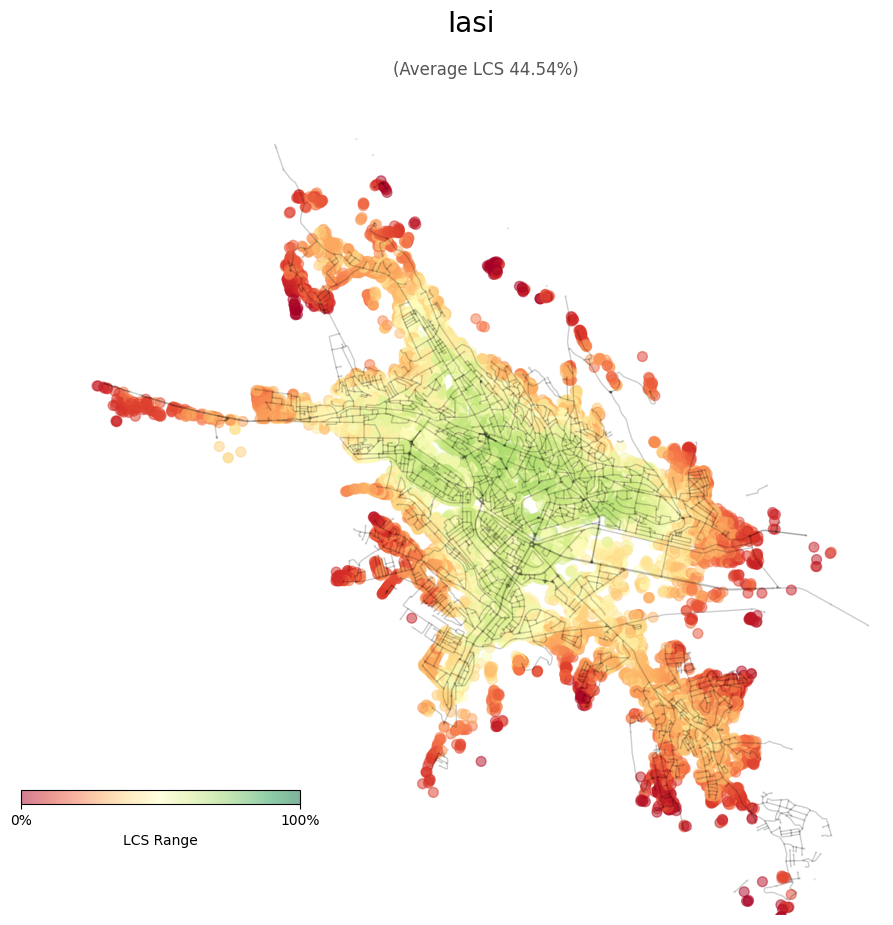

In [137]:
fig = plt.figure(figsize=(12, 12))

cmap = mpl.colormaps['RdYlGn']
plt.scatter(
    df_residential.centroid.x, 
    df_residential.centroid.y, 
    color=cmap((df_residential['lcs_perc'] / 100)), 
    alpha=0.5, 
    s=50)

ox.plot_graph(
    df_path_drive, 
    show=False, 
    close=False, 
    ax=plt.gca(), 
    edge_color='black', node_color='black', node_size=3, edge_alpha=0.1, node_alpha=0.1)

plt.set_cmap('RdYlGn')
cbar = plt.colorbar(ticks=[0, 1], shrink=0.3, orientation='horizontal', label='LCS Range', anchor=(0.0, 2), pad=0)
cbar.ax.set_xticklabels(['0%', '100%'])

plt.suptitle(f"Iasi", fontsize=20)
plt.title(f"(Average LCS {df_residential['lcs_perc'].mean():.2f}%)", y=1.06, fontsize=12, color='#555')

In [33]:
df_path_all.nodes(data=True)

NodeDataView({31200186: {'y': 47.1760921, 'x': 27.6176612, 'street_count': 3}, 31200223: {'y': 47.1748291, 'x': 27.6177442, 'street_count': 3}, 31200246: {'y': 47.1777028, 'x': 27.6092823, 'highway': 'crossing', 'street_count': 3}, 31200255: {'y': 47.1815119, 'x': 27.6022316, 'street_count': 4}, 31200265: {'y': 47.1842395, 'x': 27.5971647, 'street_count': 3}, 31200266: {'y': 47.1842138, 'x': 27.5970407, 'street_count': 3}, 31200283: {'y': 47.181506, 'x': 27.5977747, 'street_count': 3}, 31200294: {'y': 47.1685144, 'x': 27.5998555, 'street_count': 3}, 31200296: {'y': 47.1680773, 'x': 27.5991115, 'street_count': 3}, 31200297: {'y': 47.1675913, 'x': 27.5986646, 'street_count': 5}, 31200302: {'y': 47.1661973, 'x': 27.5931354, 'street_count': 4}, 31200306: {'y': 47.1649181, 'x': 27.592303, 'street_count': 4}, 31200311: {'y': 47.166537, 'x': 27.5863226, 'highway': 'traffic_signals', 'street_count': 3}, 31200318: {'y': 47.1624144, 'x': 27.5827609, 'highway': 'traffic_signals', 'street_count': 